In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/superheroes/"


In [4]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [5]:
ls {PATH}

CAX_Superhero_Test/                       Superhero_3375_SampleSubmission.csv
CAX_Superhero_Train/                      Superhero_Submission_Format.csv
CrowdANALYTIX-Best-Practices-2018-v1.pdf  test/
__MACOSX/                                 tmp/
models/                                   train/
Sample_Submission_Values.csv              valid/
subm/


In [6]:
pathtrain = PATH+'train/'
pathvalid = PATH + 'valid/'
!ls {pathtrain}

Ant-Man  Avengers  Black_Panther    Catwoman	 Hulk	   Spiderman
Aquaman  Batman    Captain_America  Ghost_Rider  Iron_Man  Superman


## preprocessing

In [7]:
subd = [sub[22:] for sub in glob(pathtrain + '*/')]
len(subd), subd

(12,
 ['/Iron_Man/',
  '/Spiderman/',
  '/Batman/',
  '/Aquaman/',
  '/Ant-Man/',
  '/Superman/',
  '/Catwoman/',
  '/Captain_America/',
  '/Hulk/',
  '/Black_Panther/',
  '/Avengers/',
  '/Ghost_Rider/'])

In [8]:
for filename in os.listdir(pathtrain):
    print(filename, type(filename))

Iron_Man <class 'str'>
Spiderman <class 'str'>
Batman <class 'str'>
Aquaman <class 'str'>
Ant-Man <class 'str'>
Superman <class 'str'>
Catwoman <class 'str'>
Captain_America <class 'str'>
Hulk <class 'str'>
Black_Panther <class 'str'>
Avengers <class 'str'>
Ghost_Rider <class 'str'>


In [44]:
# change folder name to remove spaces
for folder in os.listdir(pathtrain):
    if ' ' in folder:
        newname = folder.replace(' ','_')
        os.rename(os.path.join(pathtrain, folder),
                  os.path.join(pathtrain, newname))

In [48]:
for folder in os.listdir(pathtrain):
    os.mkdir(pathvalid+folder)

!ls {pathvalid}

Ant-Man  Avengers  Black_Panther    Catwoman	 Hulk	   Spiderman
Aquaman  Batman    Captain_America  Ghost_Rider  Iron_Man  Superman


In [70]:
for folder in glob(pathtrain + '*/'):
    print(folder[23:])
    fullset = glob(folder + '*.*')
    n = len(fullset)
    valset = get_cv_idxs(n)
    for v in valset:
        !mv {fullset[v]} {pathvalid}{folder[23:]}

Iron_Man/
Spiderman/
Batman/
Aquaman/
Ant-Man/
Superman/
Catwoman/
Captain_America/
Hulk/
Black_Panther/
Avengers/
Ghost_Rider/


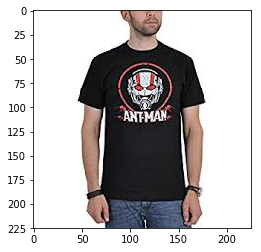

In [78]:
files = !ls {pathvalid}/Ant-Man | head
img = plt.imread(f'{pathvalid}/Ant-Man/{files[0]}')
plt.imshow(img)

In [79]:
img.shape

(225, 225, 3)

## check size

In [7]:
arch = resnet34
sz = 200
bs = 64
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch,sz))
#learn = ConvLearner.pretrained(arch, data, precompute=True)
#learn.fit(0.01,3)

In [8]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [9]:
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

(array([   3.,   31., 4382.,  427.,   13.,    3.,   14.,   13.,    2.,    2.]),
 array([ 73. , 119.7, 166.4, 213.1, 259.8, 306.5, 353.2, 399.9, 446.6, 493.3, 540. ]),
 <a list of 10 Patch objects>)

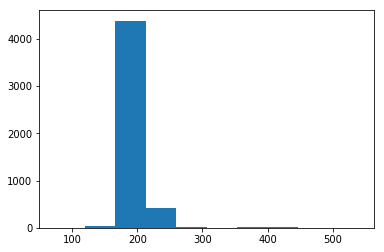

In [10]:
plt.hist(row_sz)

(array([   2.,    9.,   10.,   21., 4297.,  305.,   68.,  139.,    5.,    3.]),
 array([ 73. ,  98.7, 124.4, 150.1, 175.8, 201.5, 227.2, 252.9, 278.6, 304.3, 330. ]),
 <a list of 10 Patch objects>)

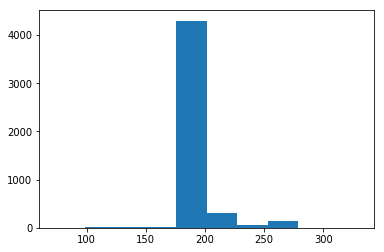

In [11]:
plt.hist(row_sz[row_sz<350])

(array([  15., 1528.,  334., 2978.,    5.,    0.,   13.,    0.,   16.,    1.]),
 array([120. , 160.2, 200.4, 240.6, 280.8, 321. , 361.2, 401.4, 441.6, 481.8, 522. ]),
 <a list of 10 Patch objects>)

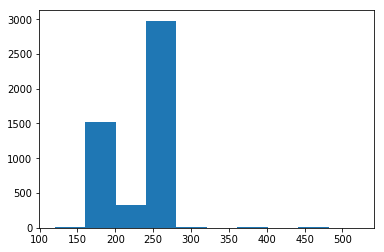

In [12]:
plt.hist(col_sz)

(array([   8.,    1.,    7.,  958.,  609.,  256.,   43., 2940.,   34.,    4.]),
 array([120., 138., 156., 174., 192., 210., 228., 246., 264., 282., 300.]),
 <a list of 10 Patch objects>)

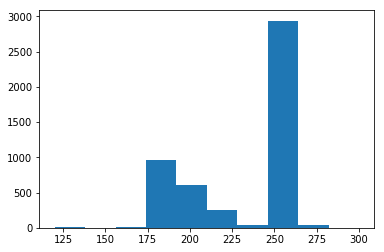

In [13]:
plt.hist(col_sz[col_sz<350])

## step 1

In [8]:
arch = resnet34
sz = 196
bs = 48

In [9]:
# create function to make it easy to vary img sz and bs for sota technique
# of increasing img sz and bs to prevent overfitting
def get_data(sz, bs):
    tfms = tfms_from_model(arch,sz, 
                           aug_tfms=transforms_side_on, 
                           max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, 
                                          tfms=tfms, bs=bs, 
                                          test_name='test')
    return data if sz>300 else data.resize(340,'tmp')   

In [10]:
data = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

#learn.fit(0.01,3)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))


100%|██████████| 71/71 [00:12<00:00,  5.60it/s]


## step 2

In [11]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▌ | 87/102 [00:00<00:00, 190.06it/s, loss=12.2]


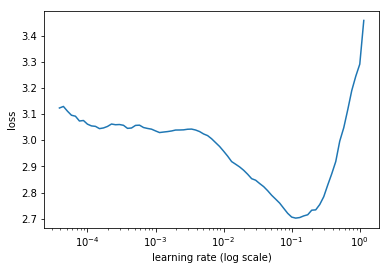

In [12]:
learn.sched.plot()

## step 3

In [13]:
learn.fit(0.01,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      2.038103   1.494437   0.507986  
    1      1.727562   1.326945   0.597569  



[1.3269451, 0.5975694420437018]

## step 4

In [14]:
learn.precompute=False
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.635797   1.30428    0.589236  
    1      1.603217   1.302744   0.592014  
    2      1.590669   1.250607   0.607292  



[1.2506069, 0.6072916686534882]

In [15]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.329769   1.067246   0.659722  
    1      1.056969   0.844091   0.74375   
    2      0.838151   0.812456   0.7625    
    3      0.771546   0.752247   0.755208  
    4      0.612778   0.696853   0.790972  
    5      0.491818   0.672132   0.792708  
    6      0.439065   0.662772   0.799653  



[0.66277236, 0.7996527850627899]

In [16]:
learn.save('196_suph')

In [17]:
learn.load('196_suph')

## repeat for sz = 255

In [18]:
learn.set_data(get_data(256,32))
learn.freeze()
#learn.precompute=True
#learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 129/153 [00:38<00:07,  3.36it/s, loss=1.93]

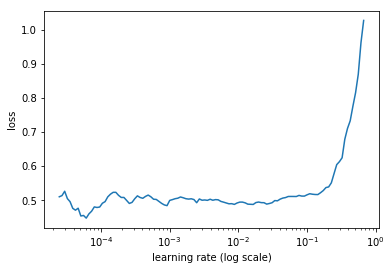

In [19]:
lrf2 = learn.lr_find()
learn.sched.plot()

In [20]:
learn.precompute=False
learn.fit(1e-3, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 0/153 [00:00<?, ?it/s]


Exception in thread Thread-26:
Traceback (most recent call last):
  File "/home/jchoo/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jchoo/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jchoo/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy   
    0      0.499656   0.672522   0.79388   
    1      0.509847   0.661885   0.795719  
    2      0.517051   0.663638   0.801233  



[0.6636375, 0.8012333968106438]

In [21]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.571698   0.620462   0.806748  
    1      0.517594   0.560128   0.821454  
    2      0.362984   0.554846   0.830704  
    3      0.424336   0.596467   0.819734  
    4      0.322179   0.558814   0.843572  
    5      0.242034   0.566265   0.84541   
    6      0.205975   0.557623   0.852823  



[0.55762345, 0.8528225807582631]

In [22]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),axis=0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.8471454880294659, 0.5012338575039309)

In [23]:
learn.save('256_suph')

In [24]:
learn.load('256_suph')

## submit

In [25]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs, y) #metrics.log_loss(y, probs)

0.044444444444444446

In [26]:
probs.shape

(3375, 12)

In [27]:
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])
df.head()

,id,Ant-Man,Aquaman,Avengers,Batman,Black_Panther,Captain_America,Catwoman,Ghost_Rider,Hulk,Iron_Man,Spiderman,Superman
0,superhero_test_981,0.000031,0.000002,0.000010,0.000001,0.000006,0.000002,2.209714e-07,0.000007,7.347269e-07,0.000006,0.999932,0.000002
1,superhero_test_1396,0.009406,0.029061,0.001229,0.009589,0.001257,0.001272,1.016960e-03,0.000528,2.308266e-04,0.934174,0.011789,0.000448
2,superhero_test_1840,0.000007,0.000079,0.000354,0.018702,0.978451,0.000015,7.715955e-05,0.001400,1.791029e-04,0.000014,0.000393,0.000327
3,superhero_test_726,0.068014,0.000838,0.192751,0.001120,0.000972,0.029064,1.635985e-03,0.051275,8.840571e-04,0.487333,0.165612,0.000501
4,superhero_test_598,0.056878,0.000010,0.000218,0.020673,0.000718,0.903222,5.438089e-04,0.000332,7.077456e-06,0.000772,0.016166,0.000460


In [28]:
df.shape

(3375, 13)

In [29]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.csv')

In [33]:
df.columns

Index(['id', 'Ant-Man', 'Aquaman', 'Avengers', 'Batman', 'Black_Panther',
       'Captain_America', 'Catwoman', 'Ghost_Rider', 'Hulk', 'Iron_Man',
       'Spiderman', 'Superman'],
      dtype='object')

In [47]:
dfidx= df.copy()

In [ ]:
df = df.copy()


In [48]:
dfidx.set_index('id', inplace=True)

In [49]:
dfidx.head()

,Ant-Man,Aquaman,Avengers,Batman,Black_Panther,Captain_America,Catwoman,Ghost_Rider,Hulk,Iron_Man,Spiderman,Superman
id,,,,,,,,,,,,
superhero_test_981,0.000031,0.000002,0.000010,0.000001,0.000006,0.000002,2.209714e-07,0.000007,7.347269e-07,0.000006,0.999932,0.000002
superhero_test_1396,0.009406,0.029061,0.001229,0.009589,0.001257,0.001272,1.016960e-03,0.000528,2.308266e-04,0.934174,0.011789,0.000448
superhero_test_1840,0.000007,0.000079,0.000354,0.018702,0.978451,0.000015,7.715955e-05,0.001400,1.791029e-04,0.000014,0.000393,0.000327
superhero_test_726,0.068014,0.000838,0.192751,0.001120,0.000972,0.029064,1.635985e-03,0.051275,8.840571e-04,0.487333,0.165612,0.000501
superhero_test_598,0.056878,0.000010,0.000218,0.020673,0.000718,0.903222,5.438089e-04,0.000332,7.077456e-06,0.000772,0.016166,0.000460


In [51]:
dfidx['max']=dfidx.idxmax(axis=1)


In [52]:
dfidx.head()

,Ant-Man,Aquaman,Avengers,Batman,Black_Panther,Captain_America,Catwoman,Ghost_Rider,Hulk,Iron_Man,Spiderman,Superman,max
id,,,,,,,,,,,,,
superhero_test_981,0.000031,0.000002,0.000010,0.000001,0.000006,0.000002,2.209714e-07,0.000007,7.347269e-07,0.000006,0.999932,0.000002,Spiderman
superhero_test_1396,0.009406,0.029061,0.001229,0.009589,0.001257,0.001272,1.016960e-03,0.000528,2.308266e-04,0.934174,0.011789,0.000448,Iron_Man
superhero_test_1840,0.000007,0.000079,0.000354,0.018702,0.978451,0.000015,7.715955e-05,0.001400,1.791029e-04,0.000014,0.000393,0.000327,Black_Panther
superhero_test_726,0.068014,0.000838,0.192751,0.001120,0.000972,0.029064,1.635985e-03,0.051275,8.840571e-04,0.487333,0.165612,0.000501,Iron_Man
superhero_test_598,0.056878,0.000010,0.000218,0.020673,0.000718,0.903222,5.438089e-04,0.000332,7.077456e-06,0.000772,0.016166,0.000460,Captain_America


In [53]:
dfidx.shape

(3375, 13)

In [54]:
dfidx.reset_index(inplace=True)

In [55]:
dfidx.head()

,id,Ant-Man,Aquaman,Avengers,Batman,Black_Panther,Captain_America,Catwoman,Ghost_Rider,Hulk,Iron_Man,Spiderman,Superman,max
0,superhero_test_981,0.000031,0.000002,0.000010,0.000001,0.000006,0.000002,2.209714e-07,0.000007,7.347269e-07,0.000006,0.999932,0.000002,Spiderman
1,superhero_test_1396,0.009406,0.029061,0.001229,0.009589,0.001257,0.001272,1.016960e-03,0.000528,2.308266e-04,0.934174,0.011789,0.000448,Iron_Man
2,superhero_test_1840,0.000007,0.000079,0.000354,0.018702,0.978451,0.000015,7.715955e-05,0.001400,1.791029e-04,0.000014,0.000393,0.000327,Black_Panther
3,superhero_test_726,0.068014,0.000838,0.192751,0.001120,0.000972,0.029064,1.635985e-03,0.051275,8.840571e-04,0.487333,0.165612,0.000501,Iron_Man
4,superhero_test_598,0.056878,0.000010,0.000218,0.020673,0.000718,0.903222,5.438089e-04,0.000332,7.077456e-06,0.000772,0.016166,0.000460,Captain_America


In [56]:
dfidx.rename(columns={'id': 'filename'}, inplace=True)
dfidx.head()


,filename,Ant-Man,Aquaman,Avengers,Batman,Black_Panther,Captain_America,Catwoman,Ghost_Rider,Hulk,Iron_Man,Spiderman,Superman,max
0,superhero_test_981,0.000031,0.000002,0.000010,0.000001,0.000006,0.000002,2.209714e-07,0.000007,7.347269e-07,0.000006,0.999932,0.000002,Spiderman
1,superhero_test_1396,0.009406,0.029061,0.001229,0.009589,0.001257,0.001272,1.016960e-03,0.000528,2.308266e-04,0.934174,0.011789,0.000448,Iron_Man
2,superhero_test_1840,0.000007,0.000079,0.000354,0.018702,0.978451,0.000015,7.715955e-05,0.001400,1.791029e-04,0.000014,0.000393,0.000327,Black_Panther
3,superhero_test_726,0.068014,0.000838,0.192751,0.001120,0.000972,0.029064,1.635985e-03,0.051275,8.840571e-04,0.487333,0.165612,0.000501,Iron_Man
4,superhero_test_598,0.056878,0.000010,0.000218,0.020673,0.000718,0.903222,5.438089e-04,0.000332,7.077456e-06,0.000772,0.016166,0.000460,Captain_America


In [34]:
ssf = pd.read_csv(PATH+'Superhero_Submission_Format.csv')
ssf.head(), ssf.columns

(           filename  Superhero
 0  superhero_test_1        NaN
 1  superhero_test_2        NaN
 2  superhero_test_3        NaN
 3  superhero_test_4        NaN
 4  superhero_test_5        NaN,
 Index(['filename', 'Superhero'], dtype='object'))

In [66]:
ssf.shape

(3375, 2)

In [57]:
# result = pd.merge(left, right, how='inner', on=['key1', 'key2'])
ans = ssf.merge(dfidx, how='inner', on='filename')

In [58]:
ans.head()

,filename,Superhero,Ant-Man,Aquaman,Avengers,Batman,Black_Panther,Captain_America,Catwoman,Ghost_Rider,Hulk,Iron_Man,Spiderman,Superman,max
0,superhero_test_1,NaN,0.001233,0.000271,0.003492,0.001082,2.101998e-03,0.003378,0.000055,0.000538,0.000236,0.059885,0.926837,0.000890,Spiderman
1,superhero_test_2,NaN,0.000002,0.000010,0.000004,0.000039,8.109657e-07,0.000221,0.000002,0.000005,0.000004,0.000236,0.000073,0.999404,Superman
2,superhero_test_3,NaN,0.000016,0.000008,0.002042,0.000013,7.913500e-05,0.000471,0.000016,0.000054,0.001746,0.995479,0.000050,0.000027,Iron_Man
3,superhero_test_4,NaN,0.003035,0.002588,0.005527,0.064983,6.603359e-01,0.015272,0.020904,0.002384,0.017200,0.054237,0.152237,0.001297,Black_Panther
4,superhero_test_5,NaN,0.007660,0.017071,0.066724,0.040261,2.287223e-02,0.229109,0.000863,0.027910,0.052788,0.242001,0.245771,0.046971,Spiderman


In [62]:
ans1 = ans[['filename', 'max']].copy()
ans1.head()

,filename,max
0,superhero_test_1,Spiderman
1,superhero_test_2,Superman
2,superhero_test_3,Iron_Man
3,superhero_test_4,Black_Panther
4,superhero_test_5,Spiderman


In [63]:
ans1.rename(columns={'max': 'Superhero'}, inplace=True)
ans1.head()

,filename,Superhero
0,superhero_test_1,Spiderman
1,superhero_test_2,Superman
2,superhero_test_3,Iron_Man
3,superhero_test_4,Black_Panther
4,superhero_test_5,Spiderman


In [64]:
ans1.shape

(3375, 2)

In [65]:
#SUBM = f'{PATH}subm/'
#os.makedirs(SUBM, exist_ok=True)
ans1.to_csv(f'{SUBM}ans1.csv')